In [1]:
from PIL import Image, ImageOps
import os, os.path
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.models import Model
import cv2
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD, Adam
import matplotlib.image as mpimg
import random
%matplotlib inline

In [ ]:
!unzip /content/CS551G_DMV_Assessment_1_Dataset.zip

In [2]:
covid_path = "/content/DMV_Assess_1_Covid-19_Dataset/Covid-19/"
normal_path = "/content/DMV_Assess_1_Covid-19_Dataset/Normal/"

In [3]:
imgs_covid = []
for i in os.listdir(covid_path):
  og_image = Image.open(covid_path+i)
  gray_image = ImageOps.grayscale(og_image)
  imgs_covid.append(gray_image)


imgs_normal = []
for i in os.listdir(normal_path):
  og_image = Image.open(normal_path+i)
  gray_image = ImageOps.grayscale(og_image)
  imgs_normal.append(gray_image)

## **Visualization**

[Text(0.5, 0, 'Normal Image'), Text(0.5, 0, 'Normal Image')]

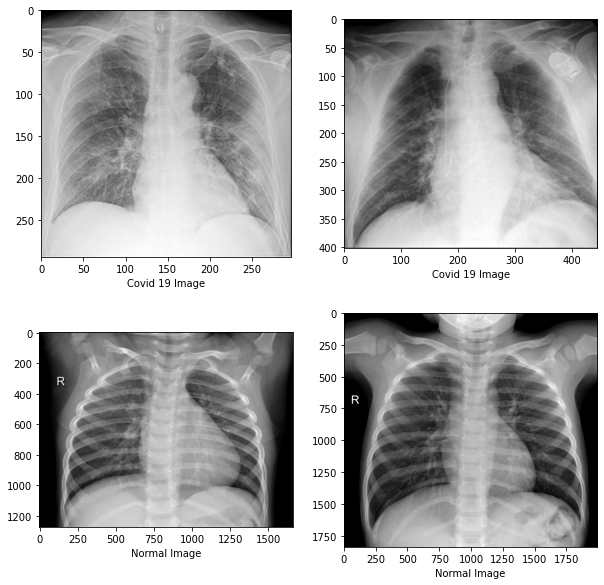

In [4]:
f, axarr = plt.subplots(2,2, figsize =(10,10))
axarr[0,0].imshow(imgs_covid[0], cmap='gray')
axarr[0,1].imshow(imgs_covid[1], cmap='gray')
axarr[1,0].imshow(imgs_normal[0], cmap='gray')
axarr[1,1].imshow(imgs_normal[1], cmap='gray')
plt.setp(axarr[0,:], xlabel='Covid 19 Image')
plt.setp(axarr[-1, :], xlabel='Normal Image')

**Setting the Image dimensions and path of images folder**

In [5]:
IMG_WIDTH=446
IMG_HEIGHT=446
img_folder=r'/content/DMV_Assess_1_Covid-19_Dataset'

In [6]:
def label_data(img_folder):
    img_data_array=[]
    class_name=[]
   
    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir1)):
       
            image_path= os.path.join(img_folder, dir1,  file)
            image= cv2.imread( image_path, cv2.IMREAD_GRAYSCALE)
            image=cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
            image=np.array(image)
            image = image.astype('float32')
            image /= 255 
            img_data_array.append(image)
            class_name.append(dir1)
    return img_data_array, class_name
img_data, class_name =label_data(img_folder)

In [7]:
data = []

for i in range(len(img_data)):
  if i <= 100:
    data.append([img_data[i],0]) #covid x-ray ; label 0
  else:
    data.append([img_data[i],1]) #normal x-ray ; label 1

In [8]:
covid_data_gan = data[0:100]

Shuffling data serves the purpose of reducing variance and making sure that models remain general and overfit less.

In [9]:
X = []
y = []

for i,j in covid_data_gan:
   X.append(i)
   y.append(j)

x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

## **GANS**

In [22]:
latent_dim = 500

In [23]:
# Get the generator model
def build_generator(latent_dim):
  i = Input(shape=(latent_dim,))
  x = Dense(1048, activation=LeakyReLU(alpha=0.2))(i)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(D, activation='tanh')(x)

  model = Model(i, x)
  return model

In [24]:
# Get the discriminator model
def build_discriminator(img_size):
  i = Input(shape=(img_size,))
  x = Dense(1048, activation=LeakyReLU(alpha=0.2))(i)
  x = Dropout(0.4)(x)
  x = Dense(2048, activation=LeakyReLU(alpha=0.2))(x)
  x = Dropout(0.4)(x)
  x = Dense(1, activation='sigmoid')(x)
  model = Model(i, x)
  return model

In [25]:
# Flatten the data
# N, H, W = x_train.shape
N = 160
H = 446
W = 446
D = H * W
x_train = np.array(x_train)
x_test = np.array(x_test)

x_train = x_train.reshape(-1, D)
x_test = x_test.reshape(-1, D)

In [26]:
# Build and compile the discriminator
discriminator = build_discriminator(D)
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=Adam(lr=0.0001, beta_1=0.5),
    metrics=['accuracy'])

# Build and compile the combined model
generator = build_generator(latent_dim)

# Create an input to represent noise sample from latent space
z = Input(shape=(latent_dim,))

# Pass noise through generator to get an image
img = generator(z)

# Make sure only the generator is trained
discriminator.trainable = False

# The true output is fake, but we label them real!
fake_pred = discriminator(img)

# Create the combined model object
combined_model = Model(z, fake_pred)

# Compile the combined model
combined_model.compile(loss='binary_crossentropy', optimizer=Adam(0.0001))

In [27]:
# Train the GAN
batch_size = 64
epochs = 15000
sample_period = 200 # every `sample_period` steps generate and save some data


# Create batch labels to use when calling train_on_batch
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

# Store the losses
d_losses = []
g_losses = []

# Create a folder to store generated images
if not os.path.exists('GANS_images'):
  os.makedirs('GANS_images')

In [28]:
#define list to store our 50 generated images (rescale 446 x 446 arrays) and label)

generated_covid = []


# A function to generate a grid of random samples from the generator
# and save them to a file
def sample_images(epoch):
  rows, cols = 1, 1
  noise = np.random.randn(rows * cols, latent_dim)
  imgs = generator.predict(noise)

  # Rescale images 0 - 1
  imgs = 0.5 * imgs + 0.5
  
  # we only start appending the images once they reach a certain iteration.
  if(epoch > 4800):
    if(len(generated_covid) < 50):
      imgs = imgs.reshape(446,446)    
      generated_covid.append([imgs,0])

  fig, axs = plt.subplots()
  axs.imshow(imgs.reshape(446, 446), cmap='gray')
  axs.axis('off')
  fig.savefig("GANS_images/%d.png" % epoch)
  plt.close()

In [29]:
for epoch in range(epochs):

  ### Train discriminator ###
  
  # Select a random batch of images
  idx = np.random.randint(0, 80, batch_size)
  x_train = np.array(x_train)
  real_imgs = x_train[idx]
  
  # Generate fake images
  noise = np.random.randn(batch_size, latent_dim)
  fake_imgs = generator.predict(noise)
  
  # Train the discriminator
  d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
  d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
  d_loss = 0.5 * (d_loss_real + d_loss_fake)
  d_acc  = 0.5 * (d_acc_real + d_acc_fake)
  
  
  ### Train generator ###
  
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model.train_on_batch(noise, ones)
  
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model.train_on_batch(noise, ones)
  
  # Append the loss metrics
  d_losses.append(d_loss)
  g_losses.append(g_loss)
  
  if epoch % 200 == 0:
    print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, \
      d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")
  
  if epoch % sample_period == 0:
    sample_images(epoch)


epoch: 1/15000, d_loss: 0.86,       d_acc: 0.17, g_loss: 0.61
epoch: 201/15000, d_loss: 0.72,       d_acc: 0.55, g_loss: 0.43
epoch: 401/15000, d_loss: 0.31,       d_acc: 0.85, g_loss: 1.07
epoch: 601/15000, d_loss: 1.66,       d_acc: 0.35, g_loss: 0.13
epoch: 801/15000, d_loss: 0.79,       d_acc: 0.54, g_loss: 0.96
epoch: 1001/15000, d_loss: 0.40,       d_acc: 0.74, g_loss: 0.97
epoch: 1201/15000, d_loss: 2.02,       d_acc: 0.23, g_loss: 0.25
epoch: 1401/15000, d_loss: 0.50,       d_acc: 0.64, g_loss: 0.99
epoch: 1601/15000, d_loss: 0.56,       d_acc: 0.63, g_loss: 1.00
epoch: 1801/15000, d_loss: 0.75,       d_acc: 0.55, g_loss: 2.03
epoch: 2001/15000, d_loss: 1.13,       d_acc: 0.36, g_loss: 0.87
epoch: 2201/15000, d_loss: 1.13,       d_acc: 0.45, g_loss: 1.19
epoch: 2401/15000, d_loss: 1.03,       d_acc: 0.48, g_loss: 1.44
epoch: 2601/15000, d_loss: 1.50,       d_acc: 0.27, g_loss: 1.23
epoch: 2801/15000, d_loss: 0.97,       d_acc: 0.52, g_loss: 1.60
epoch: 3001/15000, d_loss: 1.28,

In [30]:
print(len(generated_covid))

50


In [23]:
# !rm GANS_images/*

rm: cannot remove 'GANS_images/*': No such file or directory


# **ResNet 50 - Using original images**

In [10]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
from keras.applications.resnet50 import ResNet50

In [11]:
model = Sequential()

model.add(ResNet50(include_top=False, pooling='avg', weights='imagenet'))
#Freezing the model
model.layers[-1].trainable = False
model.add(Flatten())
model.add(BatchNormalization())
#adding more layers
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(2, activation='softmax'))

# model.layers[0].trainable = False

In [14]:
# from keras.optimizers import SGD
# opt = SGD(lr=0.01)
# model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics=['accuracy'])

model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
#this line is to ensure compatibility 
tf.config.run_functions_eagerly(True)

In [16]:
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

# test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/DMV_Assess_1_Covid-19_Dataset',
    class_mode='categorical',
     batch_size = 64,
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    '/content/DMV_Assess_1_Covid-19_Dataset', # same directory as training data
    class_mode='categorical',
     batch_size = 64,
    subset='validation') # set as validation data



model.fit_generator(
    train_generator,
    validation_data = validation_generator, 
    epochs = 100,
    validation_steps=2)

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/100
3/3 [==============================] - 17s 4s/step - loss: 0.6986 - accuracy: 0.6961 - val_loss: 0.8025 - val_accuracy: 0.5000
Epoch 2/100
3/3 [==============================] - 8s 2s/step - loss: 0.1859 - accuracy: 0.9426
Epoch 3/100
3/3 [==============================] - 8s 2s/step - loss: 0.1394 - accuracy: 0.9375
Epoch 4/100
3/3 [==============================] - 8s 2s/step - loss: 0.1116 - accuracy: 0.9500
Epoch 5/100
3/3 [==============================] - 8s 2s/step - loss: 0.1340 - accuracy: 0.9445
Epoch 6/100
3/3 [==============================] - 8s 3s/step - loss: 0.1635 - accuracy: 0.9490
Epoch 7/100
3/3 [==============================] - 8s 2s/step - loss: 0.0892 - accuracy: 0.9656
Epoch 8/100
3/3 [==============================] - 8s 2s/step - loss: 0.1437 - accuracy: 0.9457
Epoch 9/100
3/3 [==============================] - 8s 3s/step - loss: 0.0800 - accuracy: 0.9599
Epoch 10/100
3/3 [==============================] - 9s 3s/step - loss: 0.0520 - accuracy: 0.9

# **Predicting a Single Image**

In [27]:
import numpy as np
from keras.preprocessing import image

img_width, img_height = 446, 446
img = image.load_img('/content/NORMAL2-IM-0915-0001.jpeg')
img = image.img_to_array(img)
img = img/255.0
img = np.expand_dims(img, axis = 0)
print(model.predict(img))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


[[1.5201709e-04 9.9984801e-01]]


# **Combine GANs with the Covid-19 images** 

In [30]:
imgs_gans = []
gans_path = '/content/GANS_images/'
for i in os.listdir(gans_path):
  og_image = Image.open(gans_path+i)
  # gray_image = ImageOps.grayscale(og_image)
  imgs_gans.append(og_image)



In [31]:
import random

images_gans = random.sample(imgs_gans,50)
images_covid = random.sample(imgs_covid,50)
# len(images_gans)

In [32]:
final_images = images_gans + images_covid
len(final_images)

100

In [33]:
# Create a folder to store generated images
if not os.path.exists('final_images'):
  os.makedirs('final_images')

if not os.path.exists('final_images/Covid-19'):
  os.makedirs('final_images/Covid-19')

if not os.path.exists('final_images/Normal'):
  os.makedirs('final_images/Normal')

In [34]:
from PIL import Image
counter = 0
for img in final_images:
  counter+=1
  # fig.savefig("final_images5/Covid-19/covid_image%d.png" %counter)
  img.save("final_images/Covid-19/covid_imagessss%d.png" %counter)


In [35]:
counter = 0
for img in imgs_normal:
  counter+=1
  img.save("final_images/Normal/normal_imagessss%d.png" %counter)

In [37]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
from keras.applications.resnet50 import ResNet50

In [38]:
model = Sequential()

model.add(ResNet50(include_top=False, pooling='avg', weights='imagenet'))
model.layers[-1].trainable = False
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(2, activation='softmax'))

# model.layers[0].trainable = False

In [39]:
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

In [40]:
tf.config.run_functions_eagerly(True)

In [42]:
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

# test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/final_images',
    class_mode='categorical',
     batch_size = 32,
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    '/content/final_images', # same directory as training data
    class_mode='categorical',
     batch_size = 32,
    subset='validation') # set as validation data



model.fit_generator(
    train_generator,
    validation_data = validation_generator, 
    epochs = 100,
    validation_steps=2)

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/100
5/5 [==============================] - 11s 2s/step - loss: 0.1135 - accuracy: 0.9500 - val_loss: 0.3830 - val_accuracy: 0.7500
Epoch 2/100
5/5 [==============================] - 11s 2s/step - loss: 0.0724 - accuracy: 0.9750 - val_loss: 0.3535 - val_accuracy: 0.7000
Epoch 3/100
5/5 [==============================] - 11s 2s/step - loss: 0.1097 - accuracy: 0.9625 - val_loss: 0.3056 - val_accuracy: 0.8250
Epoch 4/100
5/5 [==============================] - 11s 2s/step - loss: 0.1192 - accuracy: 0.9500 - val_loss: 0.2623 - val_accuracy: 0.8750
Epoch 5/100
5/5 [==============================] - 11s 2s/step - loss: 0.0966 - accuracy: 0.9688 - val_loss: 0.2852 - val_accuracy: 0.8500
Epoch 6/100
5/5 [==============================] - 11s 2s/step - loss: 0.0656 - accuracy: 0.9750 - val_loss: 0.2139 - val_accuracy: 0.9250
Epoch 7/100
5/5 [==============================] - 11s 2s/step - loss: 0.0581 - accuracy: 0.9812 - val_loss: 0.2687 - val_accuracy: 0.8500
Epoch 8/100
5/5 [==========